In [1]:
DEBUG = False
CONFIG_FILE = f'/datascope/subaru/data/targeting/CO/test/netflow/test_002/ga-netflow_20250117200108.config'

# Calibration target distribution

Plot the distribution of the calibration targets with cobra regions (sky and instrument) to verify that there are enough flux standards and sky positions to solve the netflow problem.

In [2]:
import os, sys
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
plt.rc('font', size=6)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
if DEBUG and 'debug' not in globals():
    import debugpy
    debugpy.listen(('0.0.0.0', int(os.environ['PFS_TARGETING_DEBUGPORT'])))
    debug = True

# Imports

In [6]:
import pfs.utils

from ics.cobraOps.TargetGroup import TargetGroup
from ics.cobraOps.TargetSelector import TargetSelector

from pfs.ga.targeting.config import NetflowConfig
from pfs.ga.targeting.targets.dsph import *
from pfs.ga.targeting.instrument import *
from pfs.ga.targeting.diagram import CMD, CCD, FOV, FP, ColorAxis, MagnitudeAxis
from pfs.ga.targeting.photometry import Photometry, Magnitude, Color
from pfs.ga.targeting.projection import WcsProjection, Pointing
from pfs.ga.targeting.netflow import Netflow
from pfs.ga.targeting.io import DataFrameSerializer
from pfs.ga.targeting.io import ObservationSerializer
from pfs.ga.targeting.scripts.netflowscript import NetflowScript

from astropy.time import Time, TimeDelta

# Load the netflow config file

In [7]:
# Load the configuration

config = NetflowConfig.default()
config.load(CONFIG_FILE, ignore_collisions=True, format='.json')

print(config.targets.keys())

2025-01-17T15:29:21.628 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-17T15:29:21.660 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-17T15:29:21.667 20 cobraCoach cc connecting to fpga....
2025-01-17T15:29:21.668 30 butler     newRun: /tmp/cobra_coach/20250117_060


dict_keys(['targets', 'sky', 'fluxstd'])


# Load the calibration target lists

In [8]:
target_lists = {}

for k in config.targets:
    if config.targets[k].prefix in ['sky', 'cal']:
        target_lists[k] = NetflowScript.load_target_list(k, config.targets[k])
        print(k, config.targets[k].prefix, config.targets[k].path)

sky sky $PFS_TARGETING_DATA/data/targeting/CO/sky_region3_3h_targets.ecsv
fluxstd cal $PFS_TARGETING_DATA/data/targeting/CO/star_region3_3h_targets.ecsv


In [9]:
# List available photometry for each target list
for k, target_list in target_lists.items():
    print(k)
    for p in target_list.photometry:
        print(' ', p)
        for m in target_list.photometry[p].magnitudes:
            print('    ', m)

sky
fluxstd
  ps1
     g
     r
     i
     z
     y


# Plot calibration targets

In [18]:
pfi = SubaruPFI(instrument_options=config.instrument_options)

def plot_coordinates(ax, target_list, pointing, **kwargs):
    wcs = WcsProjection(pointing, proj='TAN')
    wfc = SubaruWFC(pointing)
    fov = FOV(projection=wcs)

    l = fov.plot_catalog(ax, target_list, size=1, **kwargs)
    pfi.plot_focal_plane(ax, fov, corners=True, projection=wfc, color='red')

    ax.set_title(target_list.name)
    ax.set_aspect('equal', adjustable='datalim')
    ax.grid(True)

    return l

def plot_cmd(ax, target_list, photometry, m1, m2, **kwargs):
    cmd = CMD([ColorAxis(Color([m1, m2])), MagnitudeAxis(m2)])
    
    l = cmd.plot_catalog(ax, target_list, size=1, **kwargs)

    ax.set_title(photometry.name)
    ax.grid(True)

    return l

def plot_target_list(target_list, pointing, title):
    cmap = plt.get_cmap('tab10')
    f, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=240)

    # Color by priority, if available
    if 'priority' in target_list.data:
        color = target_list.data['priority']
    else:
        color = 'black'

    l = plot_coordinates(axs[0], target_list, pointing, c=color, cmap=cmap)

    # Plot a color-magnitude diagram using the first two filters of the first photometric
    # system available in the target list that has at least two filters defined in the data set
    for p, photometry in target_list.photometry.items():
        if len(photometry.magnitudes) > 1:
            mm = list(photometry.magnitudes.keys())
            m1, m2 = mm[0], mm[1]
            plot_cmd(axs[1], target_list, photometry, photometry.magnitudes[m1], photometry.magnitudes[m2], c=color, cmap=cmap)

            break

    f.colorbar(l, ax=axs[1], orientation='vertical', label='Priority')
    f.suptitle(title)

2025-01-17T15:32:24.622 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-17T15:32:24.655 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-17T15:32:24.661 20 cobraCoach cc connecting to fpga....
2025-01-17T15:32:24.663 30 butler     newRun: /tmp/cobra_coach/20250117_062


/home/dobos/project/ga_targeting/python/pfs/ga/targeting/diagram/diagram.py:51: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  l = ax.scatter(x[mask][s], y[mask][s], color=color, c=c, s=size, **style)
2025-01-17T15:32:25.069 30 targeting  Extinction correction is not available in catalog `fluxstd` for magnitude `g`.
2025-01-17T15:32:25.070 30 targeting  Extinction correction is not available in catalog `fluxstd` for magnitude `r`.
2025-01-17T15:32:25.071 30 targeting  Extinction correction is not available in catalog `fluxstd` for magnitude `r`.


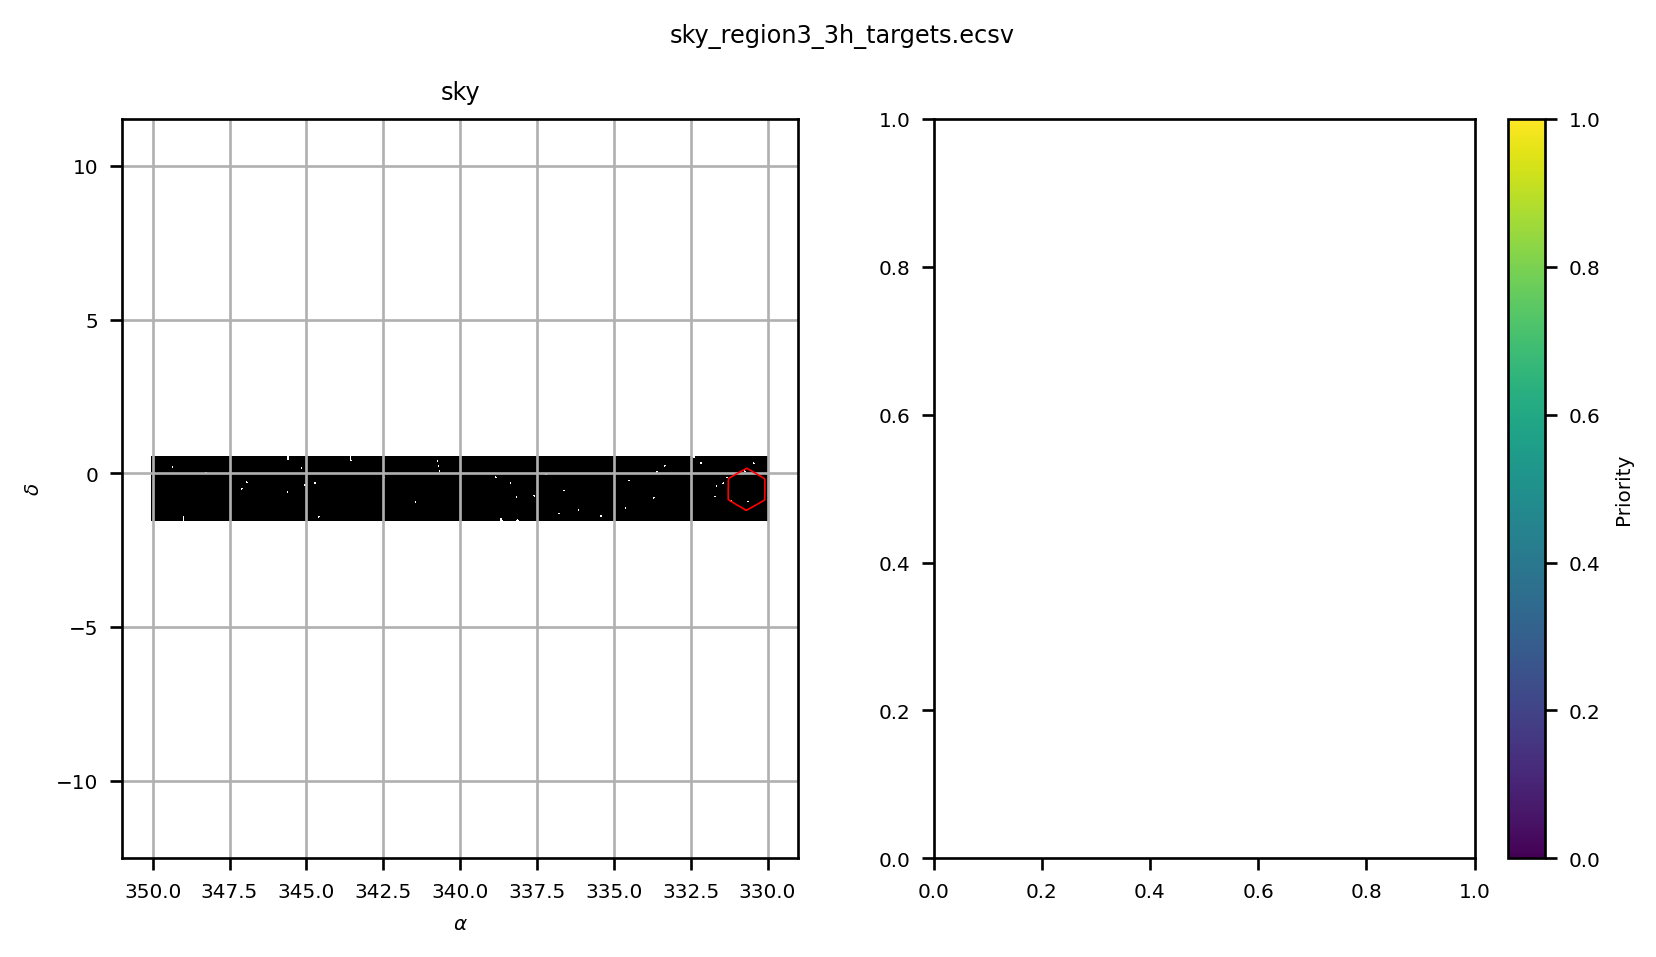

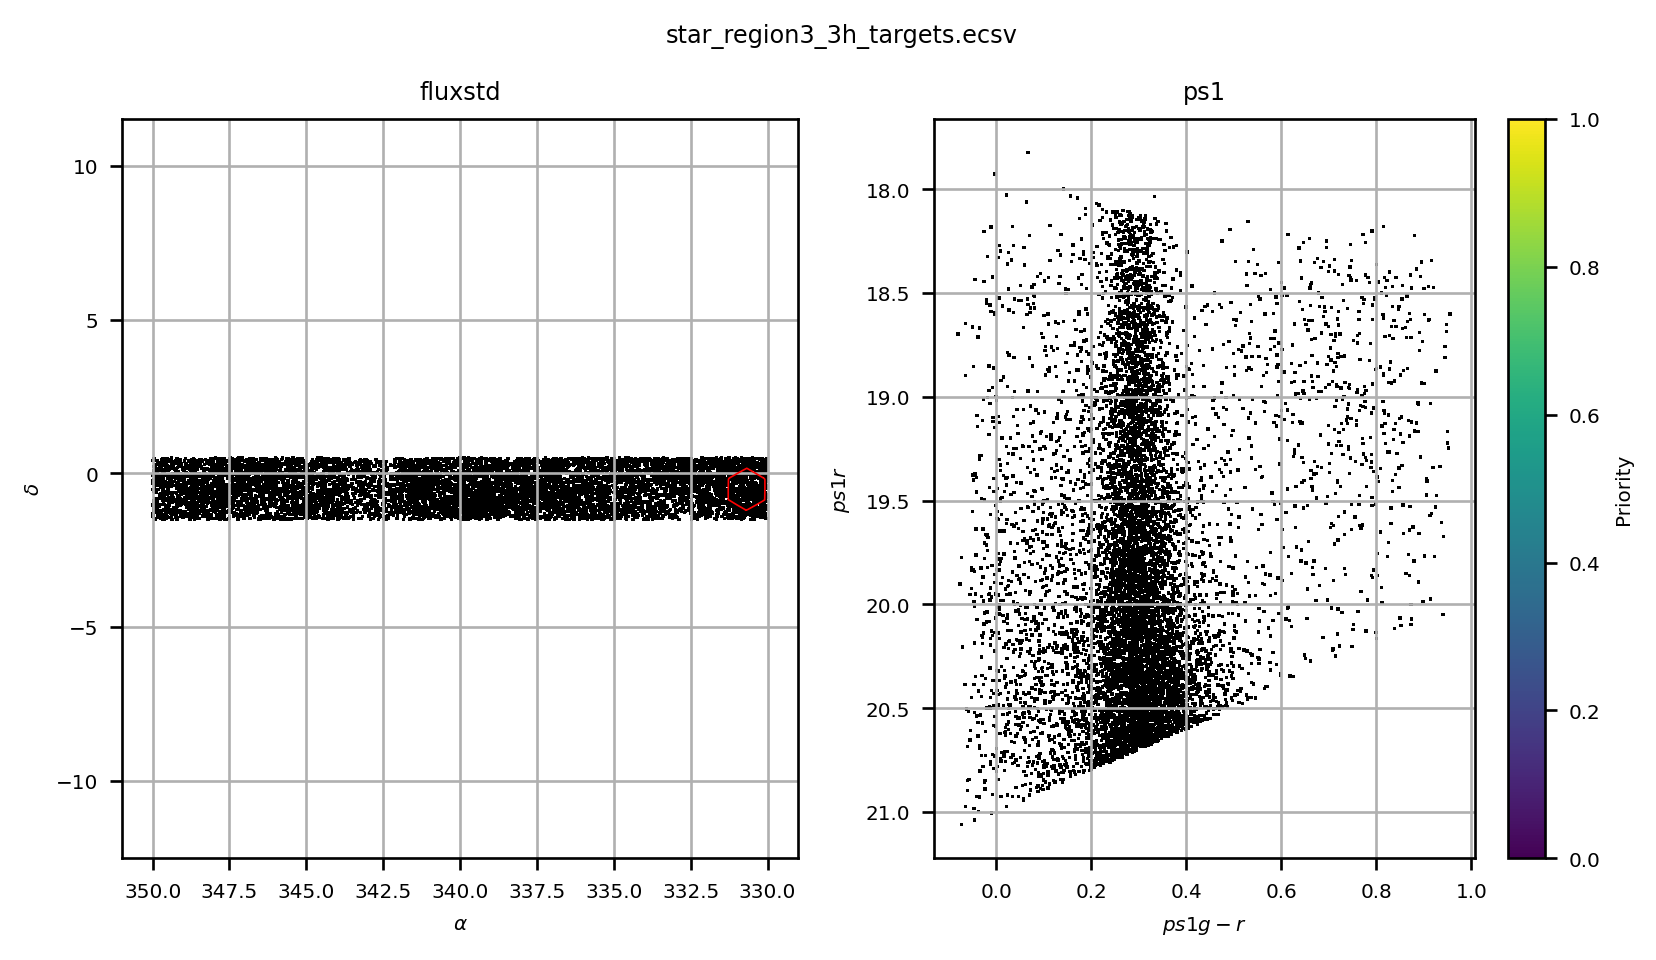

In [19]:
pointing = config.pointings[0].get_pointing()

for k in target_lists:
    _, title = os.path.split(config.targets[k].path)
    plot_target_list(target_lists[k], pointing, title)

# Plot magnitude distributions

2025-01-17T15:29:34.242 30 targeting  Extinction correction is not available in catalog `fluxstd` for magnitude `g`.
2025-01-17T15:29:34.252 30 targeting  Extinction correction is not available in catalog `fluxstd` for magnitude `r`.
2025-01-17T15:29:34.262 30 targeting  Extinction correction is not available in catalog `fluxstd` for magnitude `i`.
2025-01-17T15:29:34.273 30 targeting  Extinction correction is not available in catalog `fluxstd` for magnitude `z`.
2025-01-17T15:29:34.283 30 targeting  Extinction correction is not available in catalog `fluxstd` for magnitude `y`.


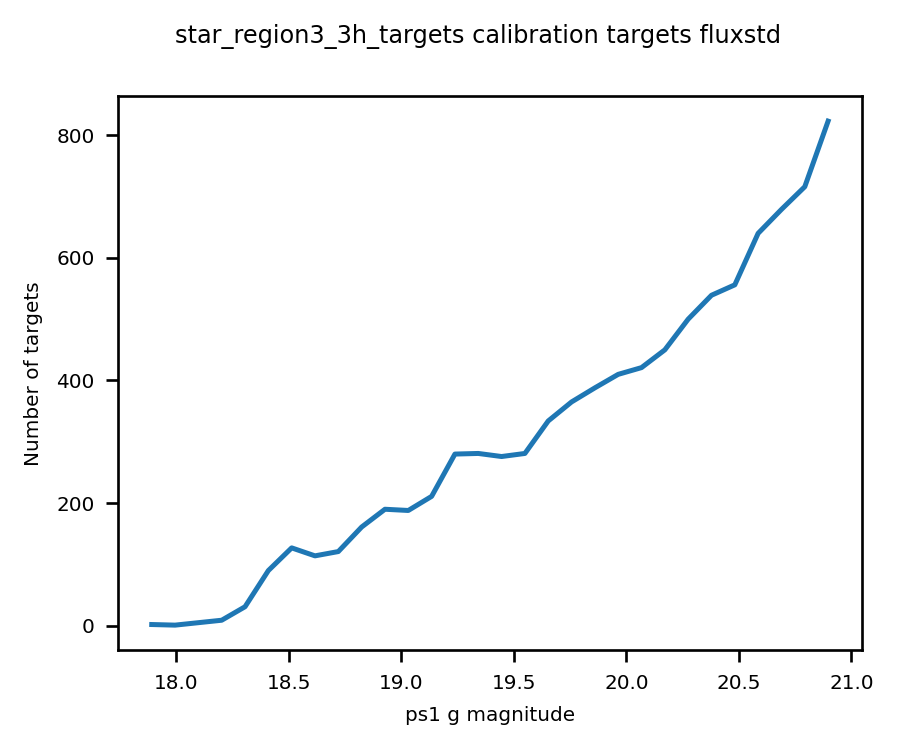

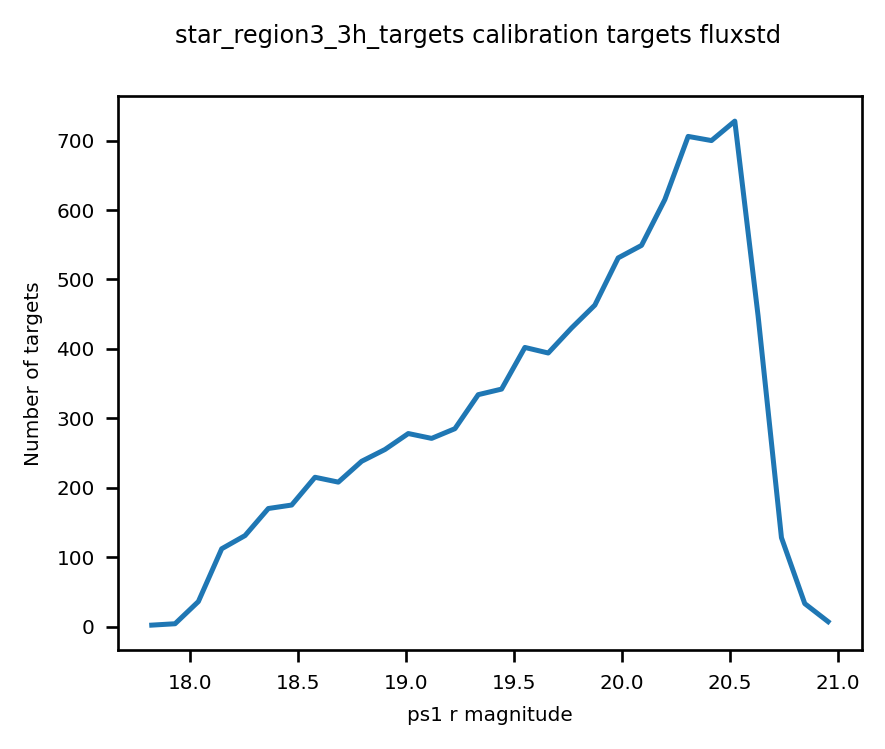

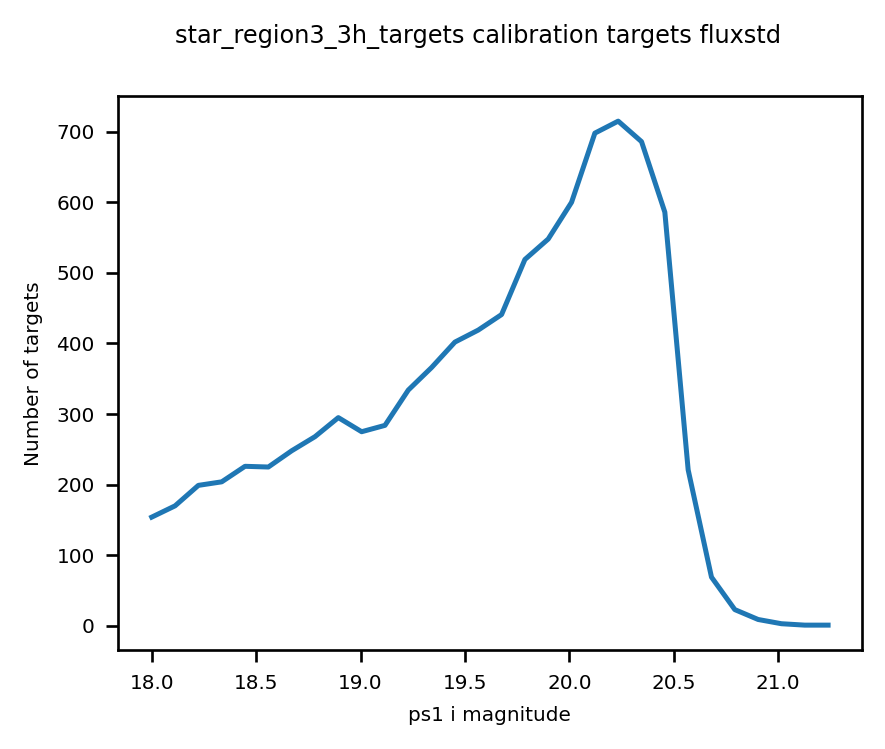

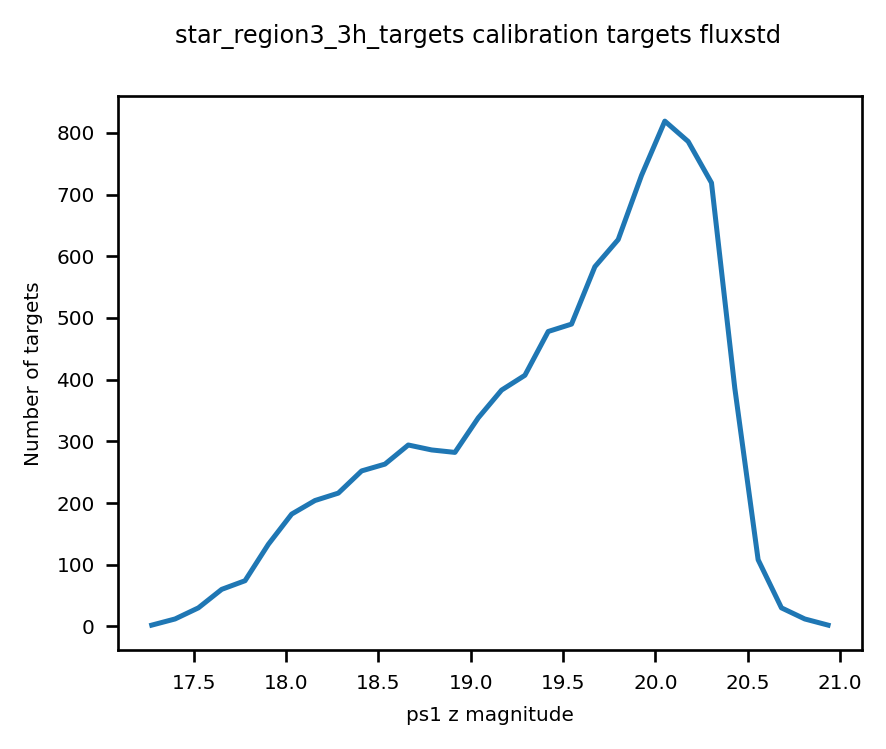

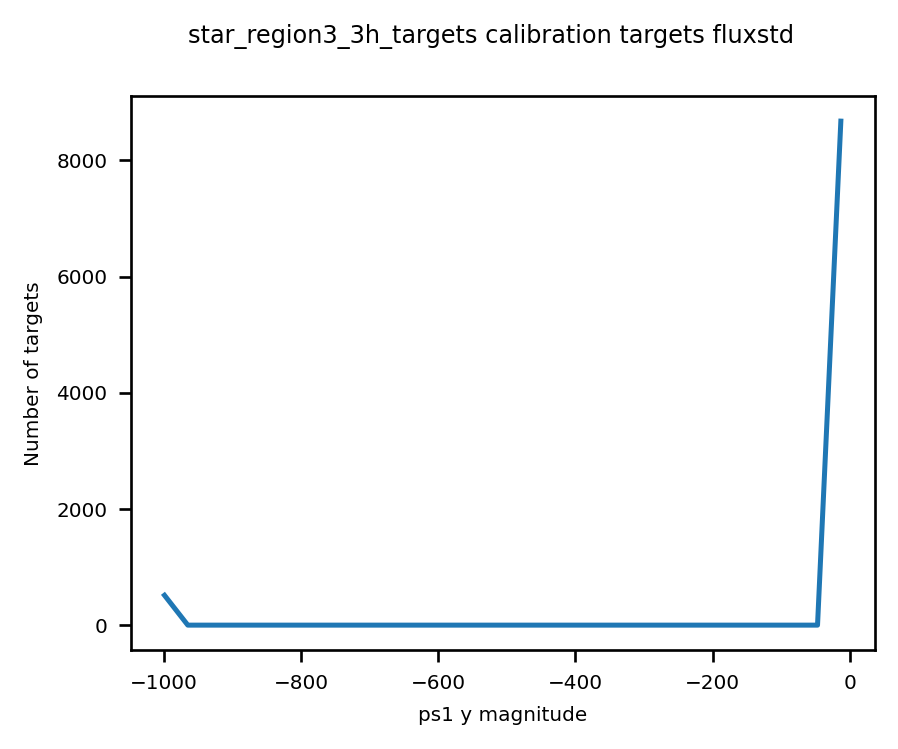

In [12]:
# Plot the magnitude distribution

for k, target_list in target_lists.items():
    if target_list.photometry is not None:
        for _, p in target_list.photometry.items():
            for _, m in p.magnitudes.items():
                f, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=240)
    
                mag, mag_err = target_list.get_magnitude(m)
                mask = np.isfinite(mag)

                hist, bins = np.histogram(mag[mask], bins=30)

                ax.plot(bins[:-1], hist)
                
                ax.set_xlabel(f'{p.name} {m.filter} magnitude')
                ax.set_ylabel('Number of targets')
                
                _, filename = os.path.split(config.targets[k].path)
                title, _ = os.path.splitext(filename)
                f.suptitle(f'{title} calibration targets {k}')

# Plot calibration target coverage

In [13]:
config.field.obs_time

'2025-08-20T11:00:00'

In [14]:
for k in config.netflow_options.cobra_groups:
    print(k, len(np.unique(config.netflow_options.cobra_groups[k].groups)))

sky_location 13
sky_instrument 32
cal_location 13


In [15]:
def get_visible(pointing, target_list):
    # Calculate focal plane coordinates
    pointing.obs_time = Time(pointing.obs_time if pointing.obs_time is not None else config.field.obs_time)
    print(pointing.ra, pointing.dec, pointing.obs_time)

    fp_pos = pfi.radec_to_fp_pos(*target_list.get_coords(), pointing=pointing)
    fp_mask = np.abs(fp_pos) < pfi.bench.radius + 10
    # print(fp_pos.shape, (np.abs(fp_pos) < 200).sum())

    # Calculate the visibility of the targets
    class DummyTargetSelector(TargetSelector):
        def run(self):
            return

        def selectTargets(self):
            return
        
    tgroup = TargetGroup(fp_pos[fp_mask])
    tselect = DummyTargetSelector(pfi.bench, tgroup)
    tselect.calculateAccessibleTargets()
    targets = tselect.accessibleTargetIndices   # shape: (cobras, targets), padded with -1

    visible = defaultdict(list)

    for cidx in range(targets.shape[0]):
        for i, fpidx in enumerate(targets[cidx, :]):
            if fpidx >= 0:
                visible[cidx].append(fpidx)

    # Create a list of all visible targets
    visible_targets = []
    for cidx in visible:
        visible_targets.extend(visible[cidx])
    visible_targets = np.unique(np.array(visible_targets))

    return visible_targets, fp_pos, fp_mask, visible

In [16]:
def plot_visible(pointing, target_list, prefix, title):

    wcs = WcsProjection(pointing, proj='TAN')
    wfc = SubaruWFC(pointing)
    fov = FOV(projection=wcs)
    fp = FP(wfc)

    visible_targets, fp_pos, fp_mask, visible = get_visible(pointing, target_list)

    # print(targets.shape, visible_targets.shape)

    # Plot the visible targets on the focal plane
    f, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=240)

    # Plot the visible targets on the focal plane
    fp.plot(axs[0], fp_pos[fp_mask].real[visible_targets], fp_pos[fp_mask].imag[visible_targets], ms=1.0, native_frame='pixel', alpha=0.5)
    pfi.plot_focal_plane(axs[0], fp, corners=True, projection=SubaruWFC(p))

    # Plot number of visible targets per cobra
    visible_count = {cidx: len(visible[cidx]) for cidx in visible}
    visible_count.update({ cidx: 0 for cidx in range(pfi.bench.cobras.nCobras) if cidx not in visible_count })
    hist = np.bincount(np.array([ v for v in visible_count.values() ]))
    axs[1].bar(np.arange(len(hist)), hist)
    axs[1].set_xlabel('Number of visible targets by cobra')
    axs[1].set_ylabel('Number of cobras')
    
    # Plot number of visible targets per cobra group
    for name, cobra_group in config.netflow_options.cobra_groups.items():
        if prefix in cobra_group.target_classes and cobra_group.groups is not None:
            # print(cobra_group.groups.min(), cobra_group.groups.max())

            # Sum up the number of visible targets per cobra group, ie. where the group identifier is the same
            group_visible = defaultdict(list)
            for cidx in visible_count:
                gidx = cobra_group.groups[cidx]
                group_visible[gidx].append(visible_count[cidx])

            group_visible_count = [ np.sum(group_visible[g]) for g in sorted(group_visible) ]
            # print(len(group_visible_count))

            axs[2].bar(np.arange(len(group_visible_count)), group_visible_count, label=name)

    axs[2].set_xlabel('Cobra group')
    axs[2].set_ylabel('Number of visible targets')
    axs[2].legend()

    f.suptitle(title)
    f.show()

330.682912 -0.518103 30 None
330.682912 -0.518103 30 None
330.682912 -0.518103 2025-08-20T11:00:00.000


/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 1122213 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


330.682912 -0.518103 30 2025-08-20T11:00:00.000
330.682912 -0.518103 2025-08-20T11:00:00.000


/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "pmsafe" yielded 9189 of "distance overridden (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


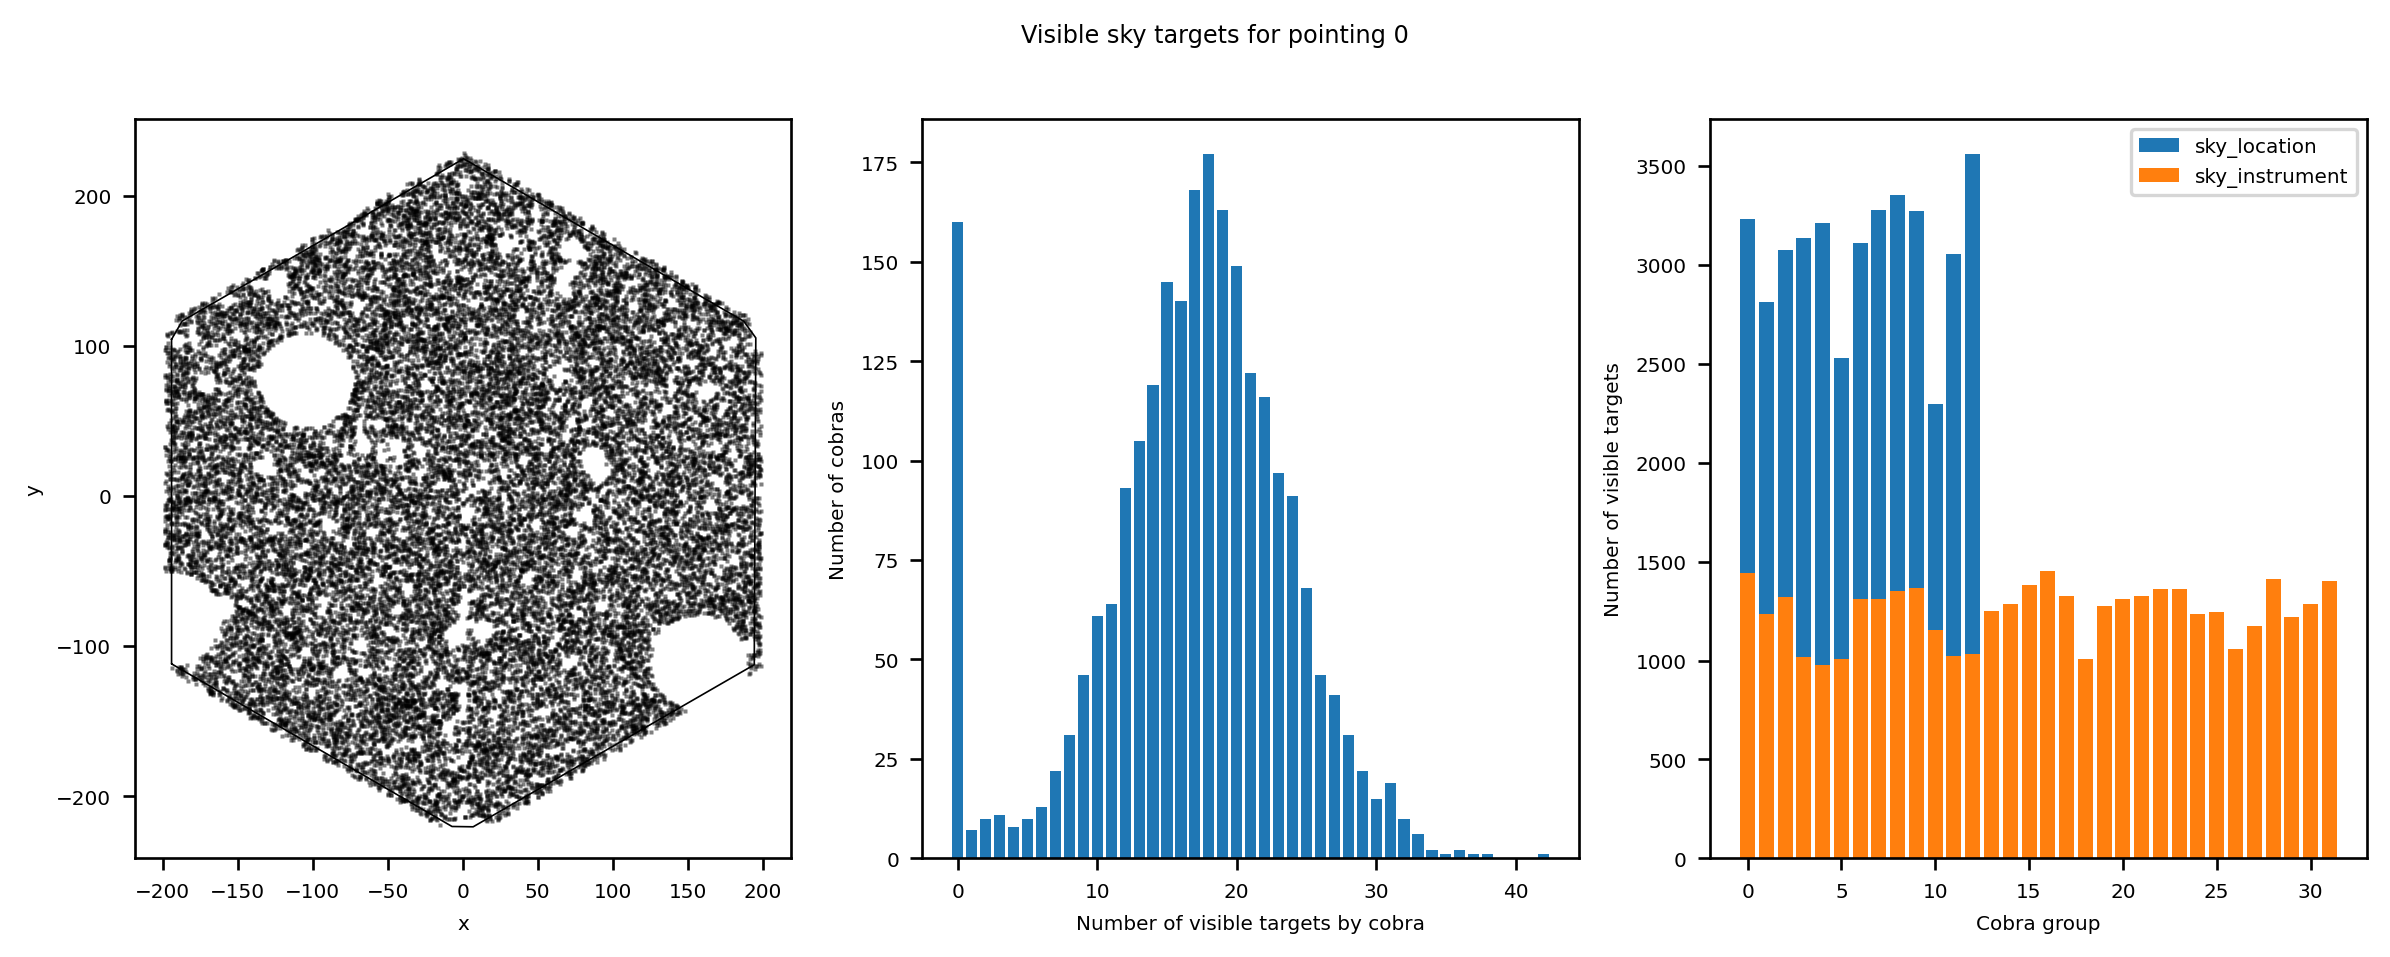

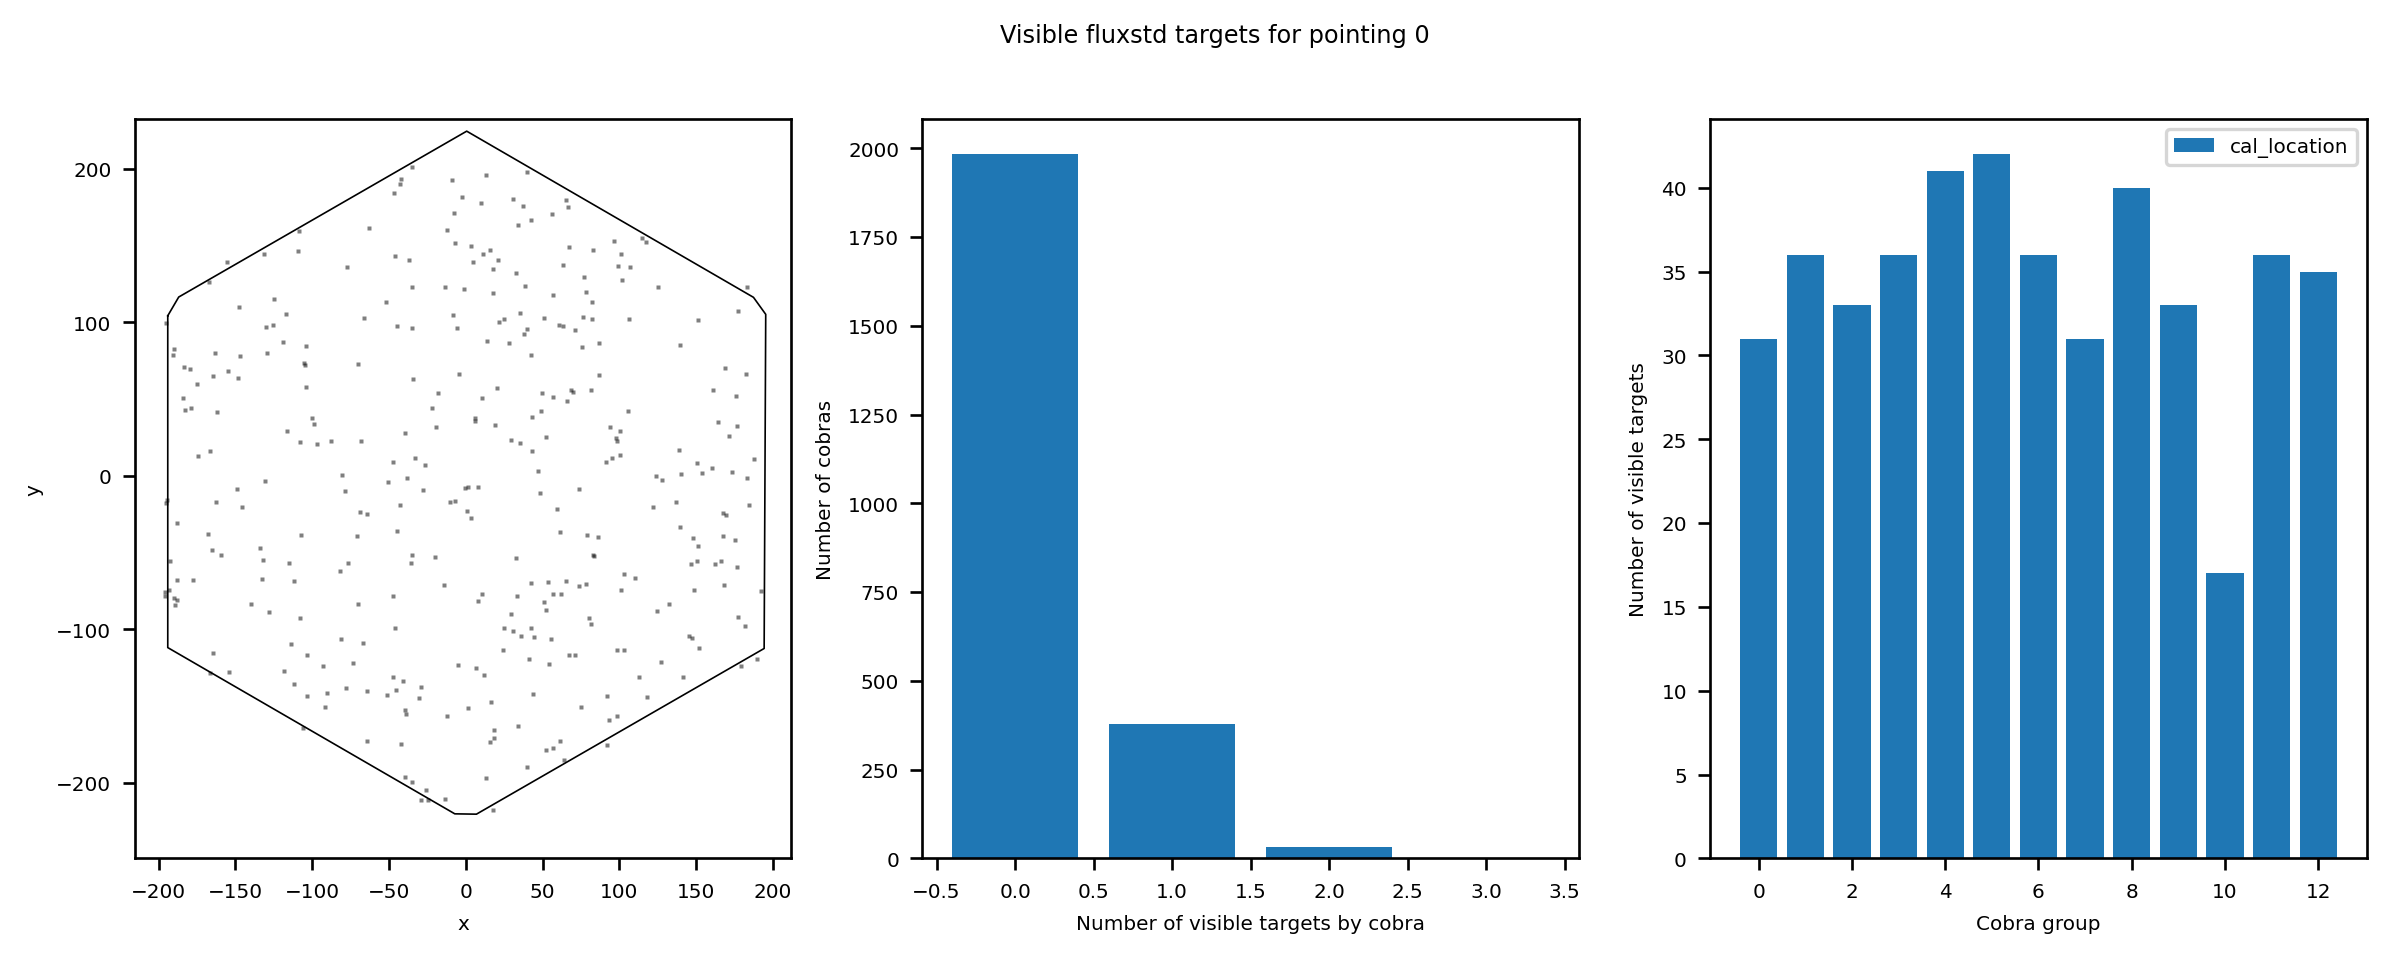

In [17]:
for k in config.targets:
    for i, p in enumerate(config.pointings):
        print(p.ra, p.dec, p.posang, p.obs_time)
        if k in target_lists:
            plot_visible(p, target_lists[k], prefix=config.targets[k].prefix, title=f'Visible {k} targets for pointing {i}')